<a href="https://colab.research.google.com/github/pushkar-khetrapal/DETR/blob/master/DETR_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install git+https://github.com/cocodataset/panopticapi.git
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-j8zxpgm7
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-j8zxpgm7
  Created wheel for panopticapi: filename=panopticapi-0.1-cp36-none-any.whl size=8317 sha256=64a3aa3c36ebd26e0f19bb951d13a09ca7271203013c66aa5b3f987d8143dea3
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6fswa_y/wheels/41/ae/17/f7e628e1ba4776ceea035aefb113ef24b6639ad5d5a2e5a5d1
Successfully built panopticapi
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 44.8MB/s 
     |████████████████████████████████| 276kB 18.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=a66d07e410b28e232b7471bf54c9c1b70d8cae609cc42d06ac67e5c5119484e0
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
  Created wheel

In [2]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

import panopticapi
from panopticapi.utils import id2rgb, rgb2id

import matplotlib.pyplot as plt

import itertools
import seaborn as sns

from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

from copy import deepcopy

# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model.eval();


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


In [3]:
def detr(im):
  img = transform(im).unsqueeze(0)
  out = model(img)
  # compute the scores, excluding the "no-object" class (the last one)
  scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
  # threshold the confidence
  keep = scores > 0.85
  # the post-processor expects as input the target size of the predictions (which we set here to the image size)
  result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

  palette = itertools.cycle(sns.color_palette())

  # The segmentation is stored in a special-format png
  panoptic_seg = Image.open(io.BytesIO(result['png_string']))
  panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()

  # We retrieve the ids corresponding to each mask
  panoptic_seg_id = rgb2id(panoptic_seg)

  # Finally we color each mask individually
  panoptic_seg[:, :, :] = 0
  for id in range(panoptic_seg_id.max() + 1):
    panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255

  # We extract the segments info and the panoptic result from DETR's prediction
  segments_info = deepcopy(result["segments_info"])
  # Panoptic predictions are stored in a special format png
  panoptic_seg = Image.open(io.BytesIO(result['png_string']))
  final_w, final_h = panoptic_seg.size
  # We convert the png into an segment id map
  panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
  panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))
  # Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
  meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")

  for i in range(len(segments_info)):
      c = segments_info[i]["category_id"]
      segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]
  # Finally we visualize the prediction
  v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)

  v._default_font_size = 20
  v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
  return v.get_image()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


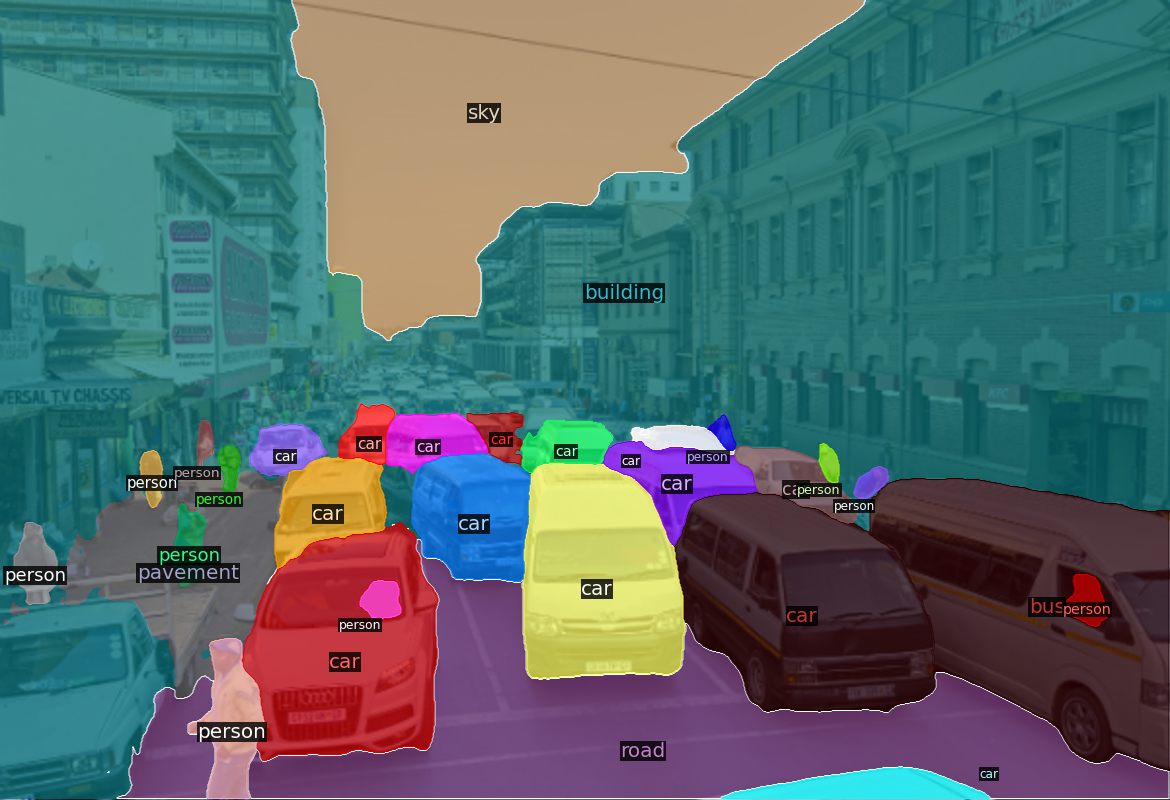

In [4]:
url = "https://d2ty3p0lzh1wfl.cloudfront.net/safetyhub_images/South%20Africa/joberg-traffic.jpg"
im = Image.open(requests.get(url, stream=True).raw)
cv2_imshow(detr(im))